In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorboard import notebook
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt 
%matplotlib inline

In [87]:
from gensim.models import Word2Vec
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, NuSVC
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.linear_model import LogisticRegression
from scipy.stats import norm
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import text_to_word_sequence, Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, Embedding, LSTM, Bidirectional, GRU, GlobalMaxPool1D
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Model
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
import pydot
import IPython
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot, plot_model

In [11]:
import seaborn as sns

In [26]:
train = pd.read_csv('./train.csv')
#test = pd.read_csv('./test.csv')


In [27]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
train_y = train[list_classes]
train_x= train["comment_text"]


In [33]:

num_samples = 80000
train_samples = 48000
val_samples = int(train_samples + ((num_samples-train_samples)/2))
samples = np.random.choice(len(train_x), num_samples)
train_X = train_x[samples[0:train_samples]]
train_Y = train_y.iloc[samples[0:train_samples]]
val_X = train_x[samples[train_samples:val_samples]]
val_Y = train_y.iloc[samples[train_samples: val_samples]]
test_X = train_x[samples[val_samples:num_samples]]
test_Y = train_y.iloc[samples[val_samples:num_samples]]

In [39]:
print(train_X.head)
print(train_Y.head)

<bound method NDFrame.head of 33340     Dr.I.K.Gill. He has devoted his life for the n...
150221    Avenged Sevenfold is a gay poser metal band. T...
94333     Your offending edit is from February 2008.  Th...
145584    "\n\n Re: Tool labs \n\nHello. I don't know ex...
138365    The goddess is defined by Abraham??? ARE YOU K...
                                ...                        
147176    "\n\nThis RS question is whether Stephen Hill,...
158273    SHUT UP AND LEAVE ME ALONE  \n\nFAGGOT! SHUT U...
52678     "\nI'm the one who added it, maybe I didn' exp...
116066    Last warning \n\nPlease stop. If you continue ...
147803    No 2+1 on the N4 yet; I travelled it only last...
Name: comment_text, Length: 48000, dtype: object>
<bound method NDFrame.head of         toxic  severe_toxic  obscene  threat  insult  identity_hate
33340       0             0        0       0       0              0
150221      1             0        0       0       0              0
94333       0             

Text(0.5, 0, 'Feature Labels')

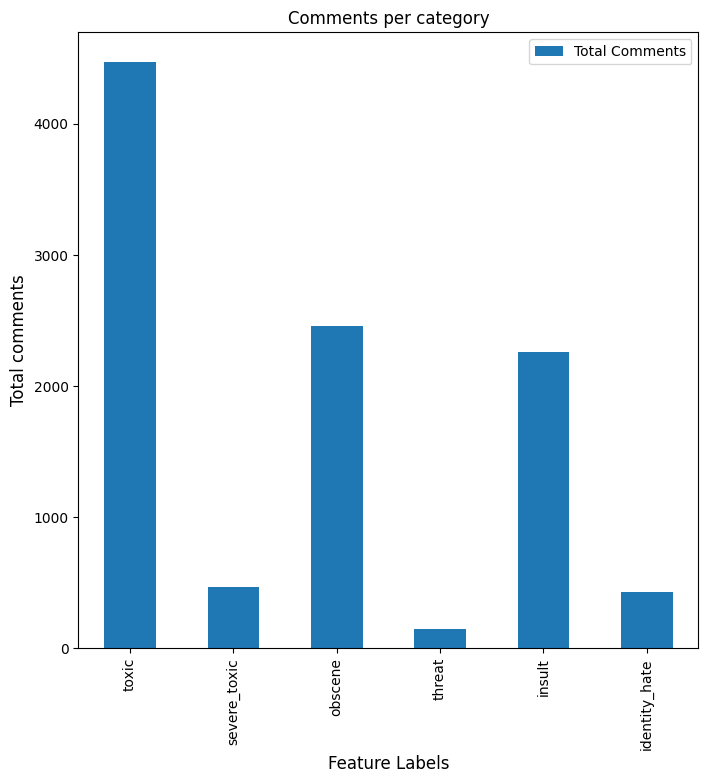

In [40]:

counts = []                                               ### A list that contains tuple which consists of class label and number of comments for that particular class 
categories = list(train_Y.columns.values)
for i in categories:
    counts.append((i, train_Y[i].sum()))

df_1 = pd.DataFrame(counts, columns=['Feature Labels', 'Total Comments'])   ### Dataframe made up of category and total number of comments
df_1.plot(x='Feature Labels', y='Total Comments', kind='bar',figsize=(8,8))
plt.title("Comments per category")
plt.ylabel('Total comments', fontsize=12)
plt.xlabel('Feature Labels', fontsize=12)

<Axes: >

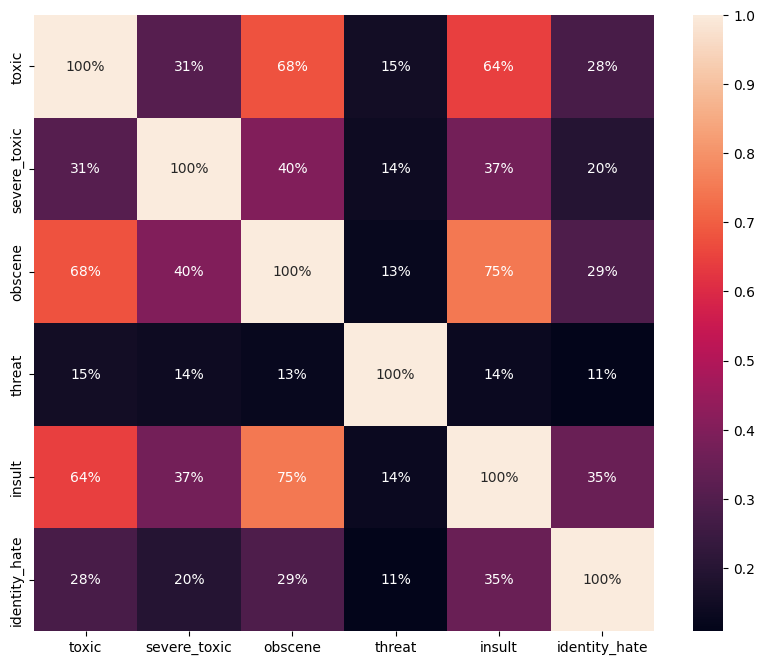

In [41]:

plt.figure(figsize=(10,8)) 
sns.heatmap(train_Y.corr(), annot =True, fmt='.0%')

In [58]:
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())
remove_n = lambda x: re.sub("\n", " ", x)
remove_non_ascii = lambda x: re.sub(r'[^\x00-\x7f]',r' ', x)
train_X = train_X.map(alphanumeric).map(punc_lower).map(remove_n).map(remove_non_ascii)
val_X = val_X.map(alphanumeric).map(punc_lower).map(remove_n).map(remove_non_ascii)
test_X = test_X.map(alphanumeric).map(punc_lower).map(remove_n).map(remove_non_ascii)



In [65]:
print(val_X)

88142     please refrain from erroneus edits to blue gra...
131168       possibly contains original research   this ...
37922                              kendrick lomar howard jr
26414     iconic   they can t include why gundagai is so...
83575        the only reason media thinks that grunge ha...
                                ...                        
68395                                  of armani or armanum
20021     vandalism  please refrain from adding nonsense...
133798        you have been reported for vandalism   mr ...
4002      squeeb i m concerned that you re going to end ...
4576      so  i m just kidding  i am a pilipino  and i w...
Name: comment_text, Length: 16000, dtype: object


In [59]:
max_words = 48000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_X)

In [77]:
train_sequences = []
for seq in tokenizer.texts_to_sequences_generator(train_X):
    train_sequences.append(seq)

val_sequences = []
for seq in tokenizer.texts_to_sequences_generator(val_X):
    val_sequences.append(seq)

    test_sequences = []

for seq in tokenizer.texts_to_sequences_generator(train_X):
    test_sequences.append(seq)
    
def find_max_list(list):
    list_len = [len(i) for i in list]
    return (max(list_len))

max_length = max(find_max_list(train_sequences),find_max_list(val_sequences), find_max_list(test_sequences))

train_padded_X = pad_sequences(train_sequences, maxlen=max_length)
val_padded_X = pad_sequences(val_sequences, maxlen=max_length)
test_padded_X = pad_sequences(test_sequences, maxlen=max_length)

#print(val_sequences[0])


In [67]:
print(val_padded_X[1:10])


[[  903  1659   308 ...     0     0     0]
 [33089  4380  4143 ...     0     0     0]
 [11034    52    37 ...     0     0     0]
 ...
 [    3    19    35 ...     0     0     0]
 [  128     6    12 ...     0     0     0]
 [  131    56    61 ...     0     0     0]]


In [92]:
def LSTM_Model_0(maxlen, max_feature):
    pretrained_weights = Input(shape = (maxlen,))
    embed_size = 128
    x = LSTM(80, return_sequences = True, name = "lstm_layer")
    x = Embedding(max_feature, embed_size)(pretrained_weights)
    x = GlobalMaxPool1D()(x)
    x = Dropout(0.1)(x)
    x = Dense(50, activation = "sigmoid")(x)
    x = Dropout(0.1)(x)
    x = Dense(6, activation = "sigmoid")(x)
    model = Model(inputs = pretrained_weights, outputs = x)
    model.compile(loss = "binary_crossentropy",
             optimizer = "adam",
             metrics = ["accuracy"])
    return model

In [89]:
lstm_0=LSTM_Model_0(max_length, train_samples)

batch_size = 128
epochs = 10
history_0 = lstm_0.fit(train_padded_X, train_Y, batch_size = batch_size, epochs = epochs, validation_data= [val_padded_X,val_Y], shuffle=True)

Epoch 1/10
375/375 [==============================] - 45s 118ms/step - loss: 0.1654 - accuracy: 0.7598 - val_loss: 0.0740 - val_accuracy: 0.9572
Epoch 2/10
375/375 [==============================] - 46s 123ms/step - loss: 0.0586 - accuracy: 0.9774 - val_loss: 0.0556 - val_accuracy: 0.9937
Epoch 3/10
375/375 [==============================] - 47s 126ms/step - loss: 0.0438 - accuracy: 0.9544 - val_loss: 0.0508 - val_accuracy: 0.9204
Epoch 4/10
375/375 [==============================] - 47s 126ms/step - loss: 0.0359 - accuracy: 0.8546 - val_loss: 0.0484 - val_accuracy: 0.7539
Epoch 5/10
375/375 [==============================] - 46s 123ms/step - loss: 0.0308 - accuracy: 0.6670 - val_loss: 0.0519 - val_accuracy: 0.8020
Epoch 6/10
375/375 [==============================] - 47s 124ms/step - loss: 0.0268 - accuracy: 0.6172 - val_loss: 0.0531 - val_accuracy: 0.3974
Epoch 7/10
375/375 [==============================] - 51s 135ms/step - loss: 0.0234 - accuracy: 0.4700 - val_loss: 0.0572 - val_ac

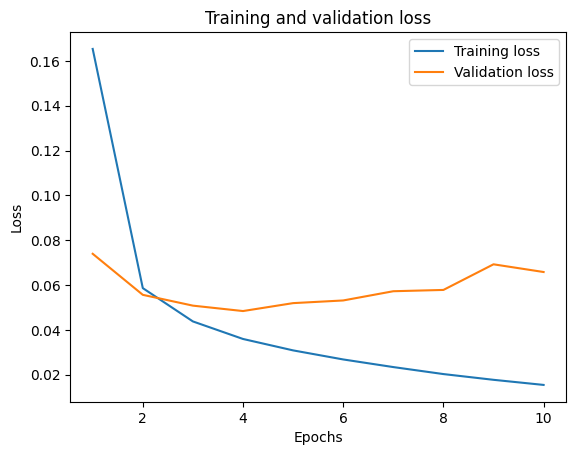

In [90]:
loss = history_0.history['loss']
val_loss = history_0.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

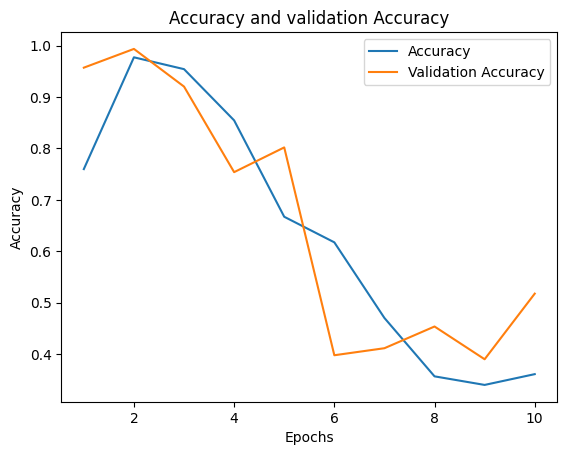

In [91]:
loss = history_0.history['accuracy']
val_loss = history_0.history['val_accuracy']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, label='Accuracy')
plt.plot(epochs, val_loss, label='Validation Accuracy')
plt.title('Accuracy and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show();

In [73]:
model = Sequential()
model.add(Embedding(max_words, 128, input_length=max_length))
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='sigmoid'))

model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1356, 128)         6144000   
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 6)                 198       
                                                                 
Total params: 6,195,686
Trainable params: 6,195,686
No

In [74]:
history = model.fit(train_padded_X, train_Y,
          batch_size=128,
          epochs=10,
          validation_data= [val_padded_X,val_Y])

Epoch 1/10
 12/375 [..............................] - ETA: 6:52 - loss: 0.6044 - accuracy: 0.1113

KeyboardInterrupt: 